## TODO
- [x] Store embeddings of one sample for each voice from the whole test set in a optimized vector store, faiss ( save to mounted drive )
- [x] Run experiment, basic similarity (could be average of samples (cosine similarity->mean) or the first one)
- [x] Run experiment, query with different levels of noise against vector store
- [x] Run experiment, query with average of multiple samples from the same audio segment (mean of embeddings -> cosine similarity) (is the cosine similarity to mean of vectors the same as the mean of cosine similarities?)
- [x] Extract faces from the videos or find a mapping between celebrity ids and names.
- [x] Downloading and processing more data, deciding how much we need (potentially ranking the most popular celebrities, or choosing those which have a lot of data)

- [ ] Re-create storage with all segments from one part of the video.
- [ ] Experiment with different threshold values for rejecting a match on.
- [ ] Create a second storage with all 6000 celebrities.
- [ ] Download longest segment for all videos of top 200 celebrities.
- [ ] Experiment by gradually adding more segments to the storage for the dataset of 200 celebrities, calculate accuracy, make plot.
- [ ] Copy vector to store to local machine, create a script ( website ) that computes and visualizes the embeddings in 2d using tsne. And allows for live recording and comparison, linking to youtube segment of the closest person.

- [ ] Write the report with the created plots and results.

*Experiments should contain some visualization, seaborn plots.*

Load repo

In [1]:
%%capture
!rm -r sample_data
# load our repository
!rm -r DT2112/
!git clone https://github.com/viktor-kth/DT2112.git
!git pull
# install all dependencies
!pip install --upgrade pip setuptools
!pip install --upgrade DT2112/


In [2]:

import random
import gdown
import numpy as np
import os

from deep_speaker.audio import read_mfcc
from deep_speaker.batcher import sample_from_mfcc
from deep_speaker.constants import SAMPLE_RATE, NUM_FRAMES
from deep_speaker.conv_models import DeepSpeakerModel
from deep_speaker.test import batch_cosine_similarity

import librosa
import librosa.display
import matplotlib.pyplot as plt
import gdown

from kth_sr.mfcc import first_k_windows
from kth_sr.embeddings import get_embedding_model

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0



## Load model

In [4]:
from pathlib import Path

# Reproducible results.
np.random.seed(123)
random.seed(123)

# Variables
SAMPLE_RATE = 16000
NUM_FRAMES = 160

# Define the model here.
model_path = "ResCNN_triplet_training_checkpoint_265.h5"
model = get_embedding_model(model_path)

# Mount file system
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Downloading...
From: https://drive.google.com/uc?id=1F9NvdrarWZNktdX9KlRYWWHDwRkip_aP
To: /content/ResCNN_triplet_training_checkpoint_265.h5
100%|██████████| 97.1M/97.1M [00:02<00:00, 46.7MB/s]


Mounted at /content/drive/


In [5]:
from deep_speaker.audio import read_mfcc, mfcc_fbank, pad_mfcc


def first_k_mfccs(audio, sample_rate, num_frames=NUM_FRAMES, k=1):
  """Call Deep Speaker preprocessing and return first k windows.

  Args:
    audio (ndarray): Audio signal.
    sample_rate (int): Sample rate.
    num_frames (int): Number of frames per segment.
    k (int): Number of segments to return.

  Returns:
    ndarray: First k segments of audio. Shape (k, 160, 64, 1)
  """

  energy = np.abs(audio)
  silence_threshold = np.percentile(energy, 95)
  offsets = np.where(energy > silence_threshold)[0]
  # left_blank_duration_ms = (1000.0 * offsets[0]) // self.sample_rate  # frame_id to duration (ms)
  # right_blank_duration_ms = (1000.0 * (len(audio) - offsets[-1])) // self.sample_rate
  # TODO: could use trim_silence() here or a better VAD.
  audio_voice_only = audio[offsets[0]:offsets[-1]]
  mfcc = mfcc_fbank(audio_voice_only, sample_rate)

  segments = []
  for i in range(k):
    start_frame = i * num_frames
    end_frame = start_frame + num_frames

    if end_frame > mfcc.shape[0]:
      # padded = pad_mfcc(mfcc[i * num_frames :], num_frames)
      # segments.append(padded)
      break

    segments.append(mfcc[start_frame:end_frame])

  return np.array(segments).reshape((-1, 160, 64, 1))

In [6]:
from os.path import split
import os

folder_path = "/content/drive/My Drive/KTH/DT2112/Project/Dataset/dev_data"  # Add a shortcut in drive to match the same path

audio_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(folder_path) for f in filenames if os.path.splitext(f)[1] == '.mp3']

storage_files = audio_files[::2]
query_files = audio_files[1::2]

for s, q in zip(storage_files, query_files): # Make sure the id's of the storage and query file match
    assert s[:7] == q[:7], f"{s[:7]} != {q[:7]}"

train_count = 750
train_storage_files = storage_files[:train_count]
train_query_files = query_files[:train_count]
train_present_count = train_count//2

test_storage_files = storage_files[train_count:]
test_query_files = query_files[train_count:]
test_present_count = len(test_storage_files) // 2

In [7]:
print(len(train_storage_files), len(train_query_files))
print(len(test_storage_files), len(test_query_files))

750 750
249 249


## Get MFCCs
For storage and querries

In [8]:
def get_mfccs(files):
    result = []
    min_segments = 1000000
    for file in files:
        file_path = os.path.join(folder_path, file)
        file = os.path.basename(file)
        celeb_id = file.split("_")[0]
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        mfccs = first_k_mfccs(signal, sr, NUM_FRAMES, k=10000)
        min_segments = min(min_segments, len(mfccs))
        result.append((mfccs, celeb_id))
    print(min_segments)
    return result

train_storage_mfccs = get_mfccs(train_storage_files)
train_query_mfccs = get_mfccs(train_query_files)
test_storage_mfccs = get_mfccs(test_storage_files)
test_query_mfccs = get_mfccs(test_query_files)

2
2
4
2


## FAISS

Setting up tools for using FAISS

In [9]:
import faiss
import numpy as np
import json
import os

from kth_sr.vectorstore import FAISS

embedding_dim = 512
vstore = FAISS(embedding_dim)

## Processing database

In [10]:
DATABASE_NAME = "celebs_1000_threshold_train"

# Load or create FAISS database for training
try:
    vstore = FAISS.load(f"{folder_path}/{DATABASE_NAME}")
    print(f"✅ FAISS database '{DATABASE_NAME}' loaded successfully with {vstore._vstore.ntotal} vectors.")
except (FileNotFoundError, ValueError, RuntimeError):
    print(f"⚠️ FAISS database '{DATABASE_NAME}' not found or empty. Recreating it...")
    vstore = FAISS(512)
    for i, (mfccs, label) in enumerate(train_storage_mfccs[:len(train_storage_mfccs) // 2]): # Only the first half of train_storage_mfccs is added
        embeddings = [model.m.predict(np.expand_dims(mfcc, axis=0), verbose=False) for mfcc in mfccs]
        embedding = np.mean(embeddings, axis=0)
        vstore.add(embedding, [label])
    vstore.save(f"{folder_path}/{DATABASE_NAME}")
    print(f"✅ New FAISS database '{DATABASE_NAME}' created and stored.")

✅ FAISS database 'celebs_1000_threshold_train' loaded successfully with 375 vectors.


# Experiments

In [11]:
query_embedding_cache = {}

### Threshold

In [49]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Function to evaluate model at different thresholds
def evaluate_thresholds(query_mfccs, true_labels, thresholds, vector_store):
    f1_scores, precisions, recalls = [], [], []


    for threshold in thresholds:
        predicted_labels = []

        n_correct = 0
        for query_mfcc, query_id in query_mfccs:
            if query_id not in query_embedding_cache:
                query_embedding_cache[query_id] = np.mean(model.m.predict(query_mfcc, verbose=False), axis=0)
            query_embedding = query_embedding_cache[query_id]

            similarities, results = vector_store.search([query_embedding], 1)

            if results[0][0] == query_id:
                n_correct += 1

            present = 1 if (similarities[0][0] < threshold) else 0
            predicted_labels.append(present)


        f1_scores.append(f1_score(true_labels, predicted_labels))
        precisions.append(precision_score(true_labels, predicted_labels))
        recalls.append(recall_score(true_labels, predicted_labels))
        print(f"Threshold: {threshold:e} - F1: {f1_scores[-1]:.4f}, Precision: {precisions[-1]:.4f}, Recall: {recalls[-1]:.4f}")

    return f1_scores, precisions, recalls

train_true_labels = [1] * (len(train_storage_mfccs) // 2) + [0] * (len(train_storage_mfccs) // 2) # Second half of query_mfccs should be detected as not present
test_true_labels = [1] * (len(test_storage_mfccs) // 2) + [0] * (len(test_storage_mfccs) // 2 + 1)


# Define thresholds and run evaluation
thresholds = np.linspace(0.01, 1, 20)
f1_scores, precisions, recalls = evaluate_thresholds(train_query_mfccs, train_true_labels, thresholds, vstore)

Threshold: 1.000000e-02 - F1: 0.0159, Precision: 1.0000, Recall: 0.0080
Threshold: 6.210526e-02 - F1: 0.0315, Precision: 1.0000, Recall: 0.0160
Threshold: 1.142105e-01 - F1: 0.0418, Precision: 1.0000, Recall: 0.0213
Threshold: 1.663158e-01 - F1: 0.0867, Precision: 1.0000, Recall: 0.0453
Threshold: 2.184211e-01 - F1: 0.1516, Precision: 0.9118, Recall: 0.0827
Threshold: 2.705263e-01 - F1: 0.3171, Precision: 0.7653, Recall: 0.2000
Threshold: 3.226316e-01 - F1: 0.4580, Precision: 0.5991, Recall: 0.3707
Threshold: 3.747368e-01 - F1: 0.5450, Precision: 0.5332, Recall: 0.5573
Threshold: 4.268421e-01 - F1: 0.6009, Precision: 0.5142, Recall: 0.7227
Threshold: 4.789474e-01 - F1: 0.6420, Precision: 0.5054, Recall: 0.8800
Threshold: 5.310526e-01 - F1: 0.6569, Precision: 0.5014, Recall: 0.9520
Threshold: 5.831579e-01 - F1: 0.6673, Precision: 0.5041, Recall: 0.9867
Threshold: 6.352632e-01 - F1: 0.6649, Precision: 0.5000, Recall: 0.9920
Threshold: 6.873684e-01 - F1: 0.6649, Precision: 0.4993, Recall:

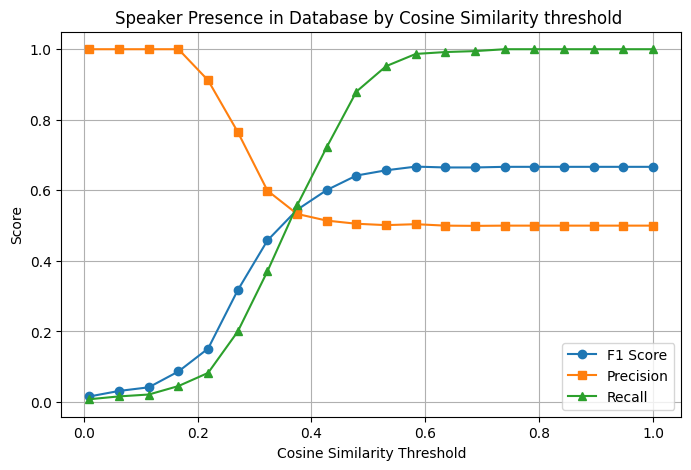

In [34]:
# Plot results
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
plt.plot(thresholds, precisions, label='Precision', marker='s')
plt.plot(thresholds, recalls, label='Recall', marker='^')
plt.xlabel("Cosine Similarity Threshold")
plt.ylabel("Score")
plt.title("Speaker Presence in Database by Cosine Similarity threshold ")
plt.legend()
plt.grid()
plt.show()

In [46]:
# Find threshold point where false positives and negatives are balanced
optimal_threshold = thresholds[np.argmax(np.array(recalls) > np.array(precisions))]
print(f"Optimal threshold: {optimal_threshold:.3f}")

Optimal threshold: 0.375


In [47]:
# Create a new FAISS database for test set
test_vstore = FAISS(512)
for i, (mfccs, label) in enumerate(test_storage_mfccs[:len(test_storage_mfccs) // 2]):
   embeddings = [model.m.predict(np.expand_dims(mfcc, axis=0), verbose=False) for mfcc in mfccs]
   embedding = np.mean(embeddings, axis=0)
   test_vstore.add(embedding, [label])

In [52]:
# Run on test set with optimal threshold
f1_test, precision_test, recall_test = evaluate_thresholds(test_query_mfccs, test_true_labels, [optimal_threshold], test_vstore)
print(f"Test Set Results - F1: {f1_test[0]:.4f}, Precision: {precision_test[0]:.4f}, Recall: {recall_test[0]:.4f}")

Threshold: 3.747368e-01 - F1: 0.4946, Precision: 0.7419, Recall: 0.3710
Test Set Results - F1: 0.4946, Precision: 0.7419, Recall: 0.3710
